In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [2]:
data=pd.read_csv("income.csv")

In [3]:
data.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [4]:
data.shape

(30000, 10)

In [5]:
data.info

<bound method DataFrame.info of        age     sex     education  education-num marital-status    workclass  \
0       27    Male       HS-grad              9  Never-married      Private   
1       47    Male       Masters             14        Married    Local-gov   
2       59    Male       HS-grad              9       Divorced     Self-emp   
3       38  Female   Prof-school             15  Never-married  Federal-gov   
4       64  Female          11th              7        Widowed      Private   
...    ...     ...           ...            ...            ...          ...   
29995   45    Male       Masters             14        Married    State-gov   
29996   33    Male       HS-grad              9        Married      Private   
29997   47    Male   Prof-school             15        Married      Private   
29998   32  Female  Some-college             10  Never-married      Private   
29999   33    Male    Assoc-acdm             12        Married     Self-emp   

              occup

In [6]:
cat=['sex','education','marital-status','workclass','occupation']

In [7]:
target=['label']

In [8]:
con=['age','hours-per-week']

In [9]:
print(f'cat_cols  has {len(cat)} columns')
print(f'cont_cols has {len(con)} columns')
print(f'y_col     has {len(target)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [10]:
for col in cat:
    data[col] = data[col].astype('category')

In [11]:
cat_szs = [len(data[col].cat.categories) for col in cat] 
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs] 

In [12]:
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [13]:
cats = np.stack([data[col].cat.codes.values for col in cat], 1)
cats[:5]

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

In [14]:
cats_tensor = torch.tensor(cats, dtype=torch.int64)

In [15]:
conts = np.stack([data[col].values for col in con], 1)
conts[:5]

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]])

In [16]:
conts_tensor = torch.tensor(conts, dtype=torch.float32)


In [17]:
y = torch.tensor(data['label'].values, dtype=torch.long)

In [18]:
b = 30000 
t = 5000   


cats_train, cats_test = cats_tensor[:b], cats_tensor[b:]
conts_train, conts_test = conts_tensor[:b], conts_tensor[b:]
y_train, y_test = y[:b], y[b:]

In [19]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        
        # Embedding layer for categorical data
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Define the feedforward layers
        layerlist = []
        n_emb = sum((nf for ni, nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in, i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        # Batch normalization for continuous variables
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Pass through feedforward layers
        x = self.layers(x)
        return x


In [20]:
model = TabularModel(emb_szs, n_cont=2, out_sz=2, layers=[50], p=0.4)
print(model)


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cats_train, conts_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 0.32130083
epoch:  26  loss: 0.31841007
epoch:  51  loss: 0.31752831
epoch:  76  loss: 0.30946460
epoch: 101  loss: 0.30460221
epoch: 126  loss: 0.30681893
epoch: 151  loss: 0.30193111
epoch: 176  loss: 0.29977223
epoch: 201  loss: 0.29703766
epoch: 226  loss: 0.29315579
epoch: 251  loss: 0.29510307
epoch: 276  loss: 0.29412898
epoch: 300  loss: 0.29014450

Duration: 20 seconds


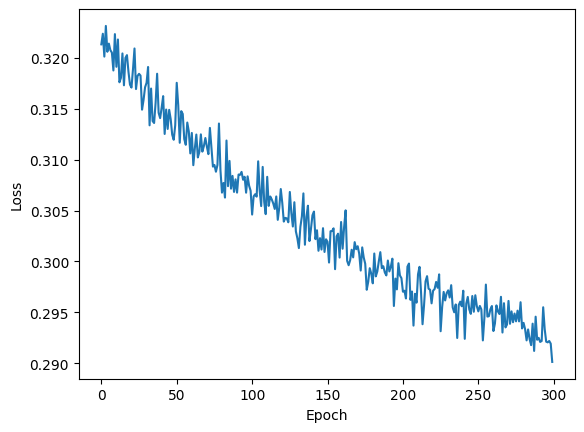

In [28]:
import matplotlib.pyplot as plt

# Convert the list of loss tensors to floats
losses_np = [loss.detach().cpu().numpy() for loss in losses]

plt.plot(losses_np)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [32]:
cats_test = cats_tensor[25000:]
conts_test = conts_tensor[25000:]
y_test = y[25000:]

In [33]:
model.eval()
with torch.no_grad():
    y_pred_test = model(cats_test, conts_test)
    loss = criterion(y_pred_test, y_test)

print(f'Test CE Loss: {loss.item():.8f}')


Test CE Loss: 0.26077694


In [34]:
y_pred_labels = torch.argmax(y_pred_test, dim=1)
correct = (y_pred_labels == y_test).sum().item()
accuracy = correct / y_test.size(0) * 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 88.20%
